# Lesson on MLP
## MLP for regression: learning a function
In this example, we will see how we can create a simple MLP that *learns an arbitrary function*.

Afterwards, we will see how well an MLP *can generalise* and **its limits** and what can we do about them.

Finally we will touch upon how we can determine the best hyper-parameters using Bayesian optimization.

## What we'll be using?

### Keras: the library for the neural networks
[Keras](https://keras.io/) is a python library that offers high-level APIs to Tensorflow: we will use this to build our model, using the `Sequential` model class. Since it is an MLP, we will be using `Dense` layers. We will be exploring what a `Dense` layer is later in this lesson.

We will also use the `print_summary`, a function usefull for displaying the built model.

If you need to install it, just run in your terminal the following:
```bash
pip install keras
```

In [1]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, InputLayer
from keras.utils import print_summary

Using TensorFlow backend.


### Matplotlib: the library for plottings graphs
[Matplotlib](https://matplotlib.org/) will be the library we will be using for plotting graphs.

If you need to install it, just run in your terminal the following:
```bash
pip install matplotlib plot_keras_history
```

In [2]:
import matplotlib.pyplot as plt
from plot_keras_history import chain_histories, plot_history

### Numpy & Sklearn: time-saver libraries
[Numpy](https://docs.scipy.org/doc/numpy/index.html) and [Sklearn](https://scikit-learn.org/stable/) are two libraries that we will be use extensively to quickly write some complex functions, such as generating and splitting the dataset.

In particular, to split the dataset we will use [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and to normalize the dataset we will use [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

If you need to install them, just run in your terminal the following:
```bash
pip install numpy
pip install sklearn
```

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Utilities
We will use [tqdm](https://github.com/tqdm/tqdm) to visualize the training progress and typing to help understand which type of variables go in and out of functions.

If you need to install it, just run in your terminal the following:
```bash
pip install tqdm
```

In [4]:
from tqdm import tqdm_notebook as tqdm
from typing import Tuple, List, Dict

### Resetting the random seed
To be able to reproduce the results, since some elements are initialized via random extractions, it is important to set the random seed as follows:

In [5]:
import os
import random
import tensorflow as tf

In [6]:
def set_seed(seed:int):
    """Set the random state of the various random extractions.
        seed:int, the seed to set the random state to.
    """
    np.random.seed(seed)
    random.seed(seed)
    tf.set_random_seed(seed)

### Quiet down some known library warnings
The tensorflow and Keras library are slightly out of tune for some functions, so tensorflow may rise some warnings. We will not worry about them and we are going to silence them as follows:

In [7]:
tf.logging.set_verbosity(tf.logging.ERROR)

## Creating the dataset
In a real scenario, clearly, we would not know the analytical description of the function we would like our network to approximate, but in our example we will create a function, `black_box`, that we will pretend to not know. We will **pretend** to have only a few, $N$, datapoints, which we will use to train our MLP.

In [8]:
N = 200

In [9]:
def black_box(x:np.ndarray)->np.ndarray:
    """Return the output for the given input of a pretended analitically unknown function.
       x:np.ndarray, input for which to determine the function values
    """
    return np.sin(x)*np.exp(x/30)

To visualize how our function looks like, even though usually we do not know, we can plot a few datapoints as follow, using `matplotlib`:

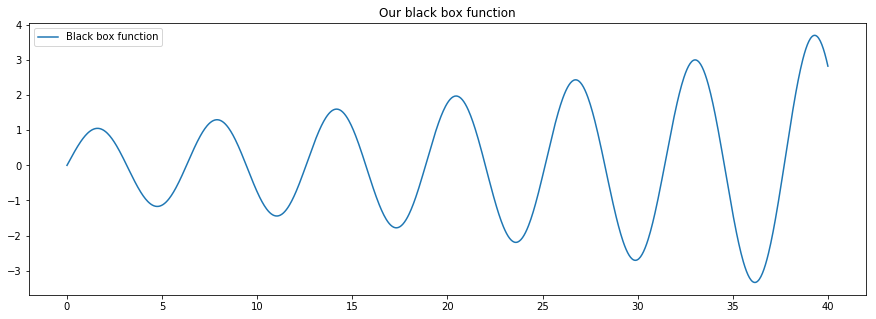

In [10]:
def plot_black_box():
    """Plot the black_box function."""
    plt.figure(figsize=(15, 5))
    x = np.linspace(0,40, num=1000,endpoint=True)
    y = black_box(x)
    plt.plot(x,y, label='Black box function')
    
plot_black_box()
plt.title("Our black box function")
plt.legend()
plt.show()

### Sampling
Lets now suppose that we have some tool that allows us to know some output $y$ of `black_box` for some given input $x$: we will call this function `black_box_sampler`. We will also **pretend** that this function can only produce a limited number $N$ of samples.

In [11]:
def black_box_sampler(N:int, seed:int=42)->Tuple[np.ndarray, np.ndarray]:
    """Return a Tuple of N input and outputs from the black_box function.
        N:int, number of samples to return.
        seed:int=42, the number of the seed to be used to render the extraction reproducible.
    """
    set_seed(seed)
    x = np.random.uniform(low=0, high=40, size=N).reshape(-1, 1)
    y = black_box(x)
    return x, y

Let's now visualize what our `black_box_sampler` returns if we suppose to obtain $N=50$ samples, keeping in mind that we do not know how the function actually looks like and that these points will be everything we know about it.

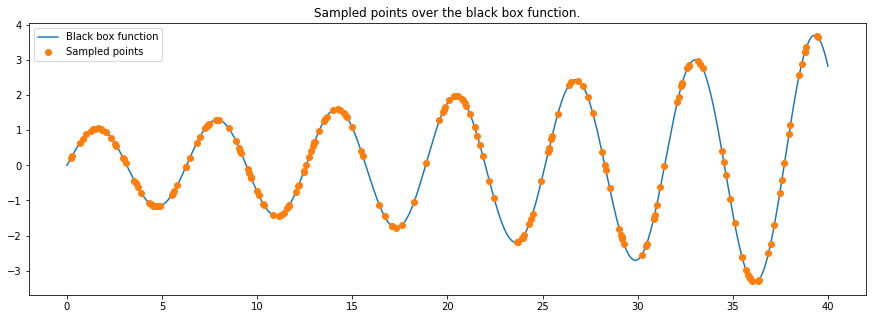

In [12]:
plot_black_box()
plt.plot(*black_box_sampler(N), "o", label='Sampled points')
plt.title("Sampled points over the black box function.")
plt.legend()
plt.show()

## Splitting the dataset: training and testing set

To train our network we will be using a portion of the sampled datapoints extracted via a random uniform distribution called **training set** and we will evaluate the obtained models using the **testing set**.

The two dataset will have size $0.7$ and $0.3$ respectively.

To split the dataset in two we will use the function `train_test_split` from the sklearn package, to which we will also set the parameter `random_state`: the extraction is randomized, but we want to be able to reproduce the results, so for every given random_state we will obtain a fixed dataset split.

In [13]:
def split_dataset(dataset:Tuple[np.ndarray, np.ndarray], seed:int, test_size:float=0.3)->Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Return the given dataset split among training a test set for the given random seed.
        dataset:Tuple[np.ndarray, np.ndarray], the dataset to split.
        seed:int, the seed to use for the random split.
    """
    return train_test_split(*dataset, test_size=test_size, random_state=seed)

Let's visualize the split:

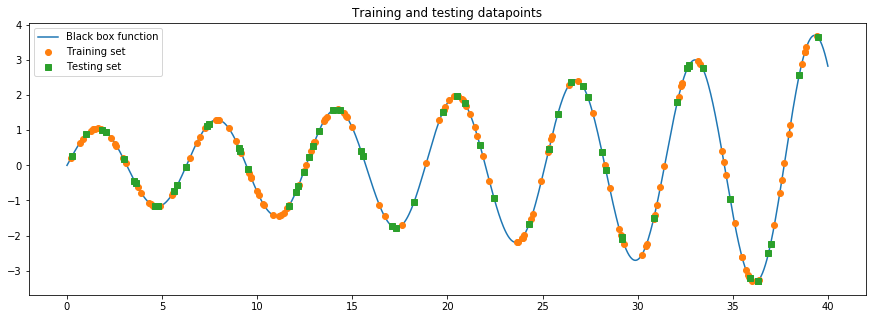

In [14]:
def plot_dataset_split(x_train:np.ndarray, x_test:np.ndarray, y_train:np.ndarray, y_test:np.ndarray):
    """Plot the goiven dataset split over the black box function.
        x_train:np.ndarray, the input reserved for the training set.
        x_test:np.ndarray, the input reserved for the testing set.
        y_train:np.ndarray, the output reserved for the training set.
        y_test:np.ndarray, the output reserved for the testing set.
    """
    plot_black_box()
    plt.plot(x_train, y_train, "o", label='Training set')
    plt.plot(x_test, y_test, "s", label='Testing set')

plot_dataset_split(*split_dataset(black_box_sampler(N), 42))
plt.title("Training and testing datapoints")
plt.legend()
plt.show()

### Holdouts: what they are and why we need them.
There is a chance that, by splitting randomly the dataset, we could get really uneven training and test set: picture an extraction that by chance split the two datasets below and above $8$.

This is clearly very unlickely, but remains in the realm of possibilities. How unlickely? 

Suppose we have $100$ datapoints, uniformely distributed from $0$ to $10$, and we split the two datasets at $0.7$ and $0.3$. What is the probability that all the $70$ points of the training set $X$ are below $8$?

$$P(x<8) = \frac{8}{10}, \quad P(\forall x \in X: x<8) = {P(x<8)}^{|X|} = 1.6\cdot 10^{-7}$$

That seems very unlickely: if that quantity were meters, it would have the size of a bacterium. But still, such things can happen.

The model would have a really hard trying to predict the values in the test set, not having seen nothing similar, and the results would be awful. Would that mean that our model is always awful?

No, it would mean that the training dataset does not represent at all the test dataset. To avoid this unfortunate separation or, on the other size of the coin, an extremely fortunate one, usually the results obtain from a network are averaged across a number of **holdouts**, that is a number of datasets split with different seeds.

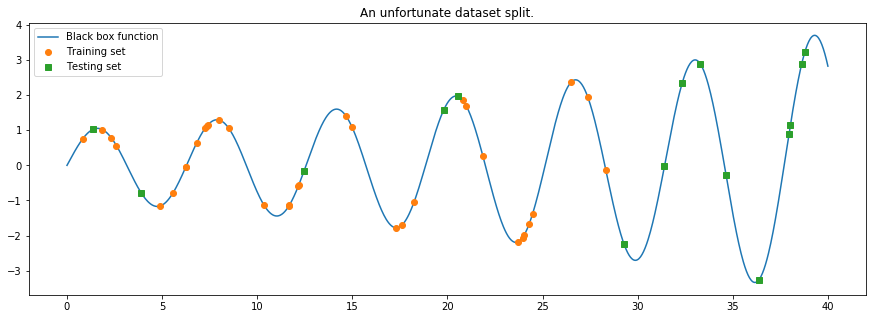

In [15]:
plot_dataset_split(*split_dataset(black_box_sampler(50), 791641))
plt.title("An unfortunate dataset split.")
plt.legend()
plt.show()

### Scaling the dataset datapoints according to training set

Since most activation functions image is limited, take the *sigmoid* for example, we have to normalize the values in our dataset using sklearn's `MinMaxScaler`, which simply works as follows:
$$X_{\text{scaled}} = \frac{X-\min{X}}{\max{X} - \min{X}}$$

Here we show the codomain of some commonly used activation functions:

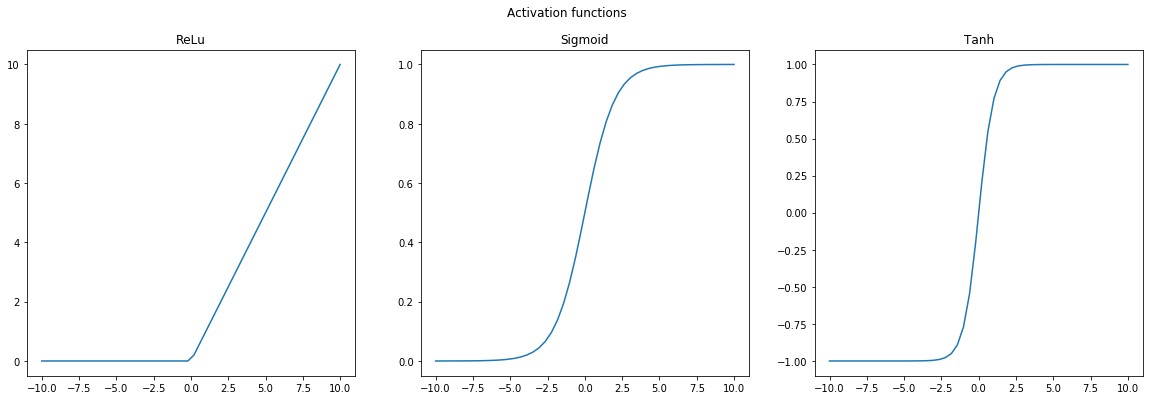

In [16]:
activation_functions = {
    "ReLu":lambda x:np.maximum(x, 0),
    "Sigmoid":lambda x:1 / (1 + np.exp(-x)),
    "Tanh":np.tanh
}
_, axes = plt.subplots(1, len(activation_functions), figsize=(20,6))
x = np.linspace(-10,10, endpoint=True)
for i, (name, function) in enumerate(activation_functions.items()):
    axes[i].plot(x, function(x))
    axes[i].set_title(name)
plt.suptitle("Activation functions")
plt.show()

In [17]:
def scale(train:np.ndarray, test:np.ndarray):
    """Return scaler, scaled training and test vectors based on given training vector."""
    scaler = MinMaxScaler().fit(train)
    return scaler, scaler.transform(train), scaler.transform(test)

In [18]:
def scale_split_dataset(dataset:Tuple[np.ndarray, np.ndarray], seed:int, test_size:float=0.3):
    """Return split and scaled dataset."""
    x_train, x_test, y_train, y_test = split_dataset(dataset, seed, test_size)
    return (*scale(x_train, x_test), *scale(y_train, y_test))

## Creating the Multi Layer Perceptron model

We will now finally proceed to create a simple MLP model, composed by the following layers:

- **Input layer:** one neuron, with ReLu activation function. 
- **Hidden layers:** `deapth` layers with ReLu activation function, each one with `breath` neurons.
- **Output layer:** one neuron, with Sigmoid activation function. 

![MLP](https://github.com/LucaCappelletti94/Master-in-Bioinformatics-and-Functional-genomics/blob/master/1%20-%206:05:2019%20-%20Lesson%20on%20MLP/MLP.png?raw=true)

Every level is a [Dense](https://keras.io/layers/core/) layer, meaning there's an arc from every neuron of any given layer to every neuron of the next layer: for eached one of these arcs there is one corresponding parameter.

Here's a schema of a Dense Layer:
![Dense Layer](https://github.com/LucaCappelletti94/Master-in-Bioinformatics-and-Functional-genomics/blob/master/1%20-%206:05:2019%20-%20Lesson%20on%20MLP/Dense.png?raw=true)

### Loss function
As loss function we will be using the **[mean squared error](https://keras.io/losses/)** (MSE):
$$\text{MSE} = \frac{1}{N}\sum_{i=1}^n {\left(Y_y - \widehat{Y}_i\right)}^2$$
Where $N$ is the number of examples, $Y_i$ is the true value and $\widehat{Y}_i$ is the predicted one.
### Optimizer
As optimizer we will be using the **[Stochastic gradient descent](https://keras.io/optimizers/)**, in its mini-batched version. This optimizer updates the weights after each mini-batch using the average loss partial derivative:
$$w_{i, j} \leftarrow w_{i, j}-\eta_{t} \frac{1}{\left|S_{t}\right|} \sum_{s \in S_{t}} \frac{\partial \ell_{s}(W)}{\partial w_{i, j}}$$
where \(S_t\) is a subset of fixed cardinality extracted from the training set and $\eta_{t}$ is a step coefficient, which can either be constant or be defined by a function, for example, often, as a momentum.

## Metrics: how to evaluate the training
Alongside the loss function, we will use the area under the ROC and PR curves, called approprietly auroc and auprc.

In [19]:
def auroc(y_true, y_pred)->float:
    score = tf.metrics.auc(y_true, y_pred, curve="ROC", summation_method="careful_interpolation")[1]
    K.get_session().run(tf.local_variables_initializer())
    return score

In [20]:
def auprc(y_true, y_pred)->float:
    score = tf.metrics.auc(y_true, y_pred, curve="PR", summation_method="careful_interpolation")[1]
    K.get_session().run(tf.local_variables_initializer())
    return score

## Building the Keras model
To build the model, we will use the `Sequential` model: simply put, a stack of layers:
```python
model = Sequential([])
```
We start by adding the `InputLayer`, that simply describes the size of the input, in our case `(1,)`:
```python
model = Sequential([
    InputLayer(input_shape=(1,))
])
```
*The comma in `(1,)` is required, as it is a Tuple! Otherwise `(1)==1`!*

We proceed then to add the first `Dense` layer of the multi-layer perceptron, that is basically a single perceptron:
```python
model = Sequential([
    InputLayer(input_shape=(1,)),
    Dense(1, activation="relu")
])
```
Now we add a list of hidden layers that we can visualize as a rectangle, with width `depth` and height `breath`:
```python
model = Sequential([
    InputLayer(input_shape=(1,)),
    Dense(1, activation="relu"),
    *[Dense(breath, activation="relu") for i in range(depth)]
])
```
And finally we add the output layer:
```python
model = Sequential([
    InputLayer(input_shape=(1,)),
    Dense(1, activation="relu"),
    *[Dense(breath, activation="relu") for i in range(depth)],
    Dense(1, activation="sigmoid")
])
```
Now we just have to compile the model, specifying an **optimizer**, **loss** function and which **metrics** we want to keep track of:
```python
model.compile(
    optimizer='nadam',
    loss='mean_squared_error',
    metrics=[auroc, auprc]
)
```

In [21]:
def mlp(breath:int, depth:int, random_state:int=42, optimizer:str="nadam"):
    """Return a multi-layer perceptrone with `depth` hidden layers, each one with `breath` neurons.
        breath:int, number of neurons per hidden layer.
        depth:int, number of hidden layers.
        random_state:int, seed to initializing weights.
        optimizer:str, the optimizer to be used, by default we use `nadam`
    """
    set_seed(random_state)
    model = Sequential([
        InputLayer(input_shape=(1,)),
        Dense(1, activation="relu"),
        *[Dense(breath, activation="relu") for i in range(depth)],
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=[auroc, auprc]
    )
    return model

In [22]:
def fit(model:Sequential, x_train:np.ndarray, x_test:np.ndarray, y_train:np.ndarray, y_test:np.ndarray, epochs:int, initial_epoch:int, batch_size:int):
    """Train the given model on given train data for the given epochs number.
        model:Sequential, the model to be trained.
        x_train:np.ndarray, the input for training the model.
        x_test:np.ndarray, the input for testing the model.
        y_train:np.ndarray, the output labels for training the model.
        y_test:np.ndarray, the output labels for testing the model.
        epochs:int, number of epochs for which to train the model.
        initial_epoch:int, starting epoch.
        batch_size:int, number of datapoints per training batch.
    """
    return model.fit(
        x_train,
        y_train,
        shuffle=True,
        verbose=0,
        validation_data=(x_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        initial_epoch=initial_epoch
    )

In [23]:
def plot_learning(model, x_train, x_test, y_train, y_test, x_scaler, y_scaler, epochs):
    plot_dataset_split(
        x_scaler.inverse_transform(x_train),
        x_scaler.inverse_transform(x_test),
        y_scaler.inverse_transform(y_train), 
        y_scaler.inverse_transform(y_test)
    )
    x = np.linspace(0,1,endpoint=True, num=10000).reshape(-1, 1)
    y = model.predict(x)
    
    plt.plot(
        x_scaler.inverse_transform(x),
        y_scaler.inverse_transform(y),
        label='Prediction'
    )
    plt.legend()
    plt.title("Black box prediction after {total_epochs} epochs.".format(total_epochs=epochs))
    plt.show()

In [24]:
base_epochs = 200
steps = 5
batch_size = 16
breath, deapth = 15, 6

In [25]:
our_first_model = mlp(breath, deapth)
print_summary(our_first_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                30        
_________________________________________________________________
dense_3 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_4 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_5 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_6 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_7 (Dense)              (None, 15)                240       
__________

In [26]:
x_scaler, x_train, x_test, y_scaler, y_train, y_test = scale_split_dataset(black_box_sampler(N), 42)

To see how the network learns, we will plot the learning rate every few epochs. We will use an exponential function to determine the epoch numbers.

In [27]:
def get_epochs(step:int, base_epochs:int)->int:
    """Return the number of epochs to train for at the `step` step.
        step:int, number of the step.
        base_epochs:int, starting number of epochs.
    """
    return int(base_epochs*np.exp(step))

In [28]:
def train(model:Sequential, base_epochs:int, steps:int, x_train:np.ndarray, x_test:np.ndarray, y_train:np.ndarray, y_test:np.ndarray):
    total_epochs = 0
    history = None
    for step in tqdm(range(steps)):
        epochs = get_epochs(step, base_epochs)
        history = chain_histories(fit(
            model,
            x_train,
            x_test,
            y_train,
            y_test,
            epochs+total_epochs,
            total_epochs, 
            batch_size
        ).history, history)
        total_epochs+=epochs
        plot_learning(
            model,
            x_train,
            x_test,
            y_train,
            y_test,
            x_scaler,
            y_scaler,
            total_epochs
        )
        plot_history(history)

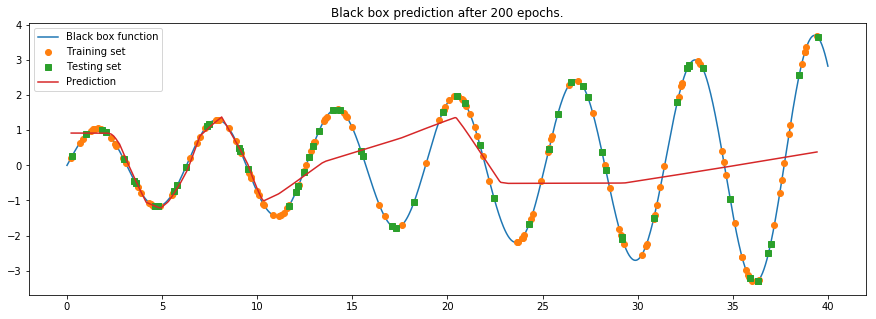

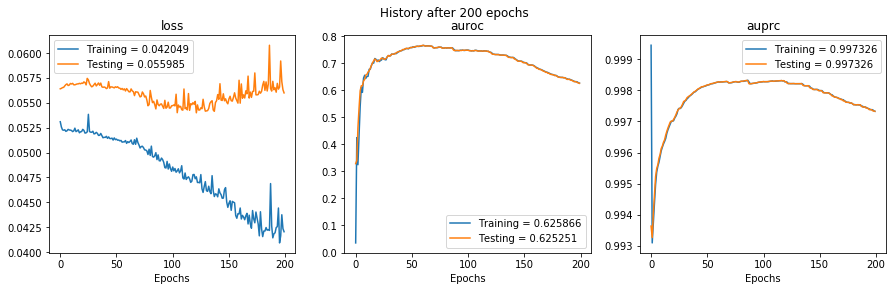

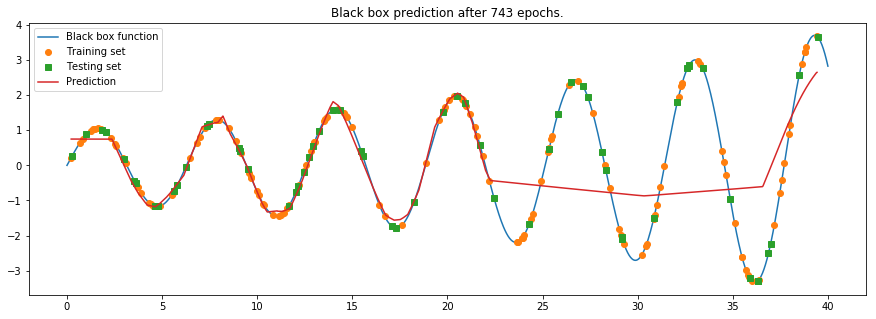

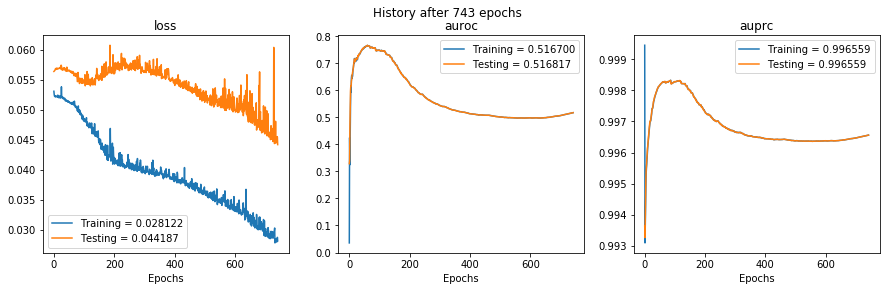

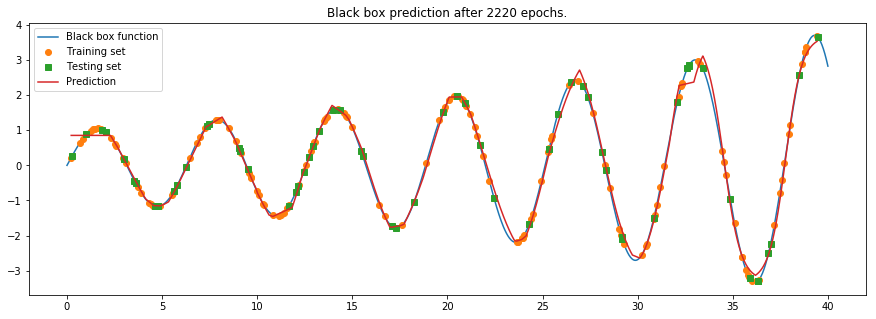

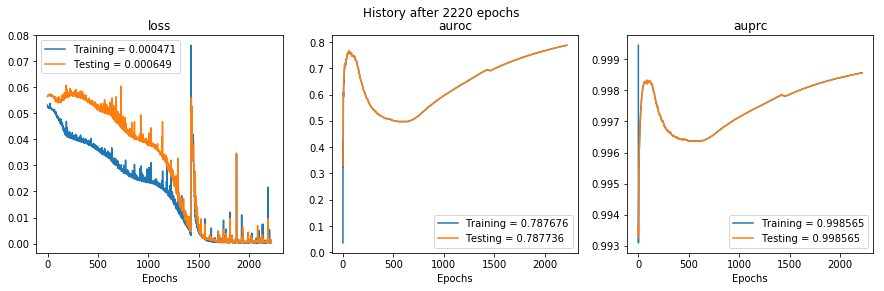

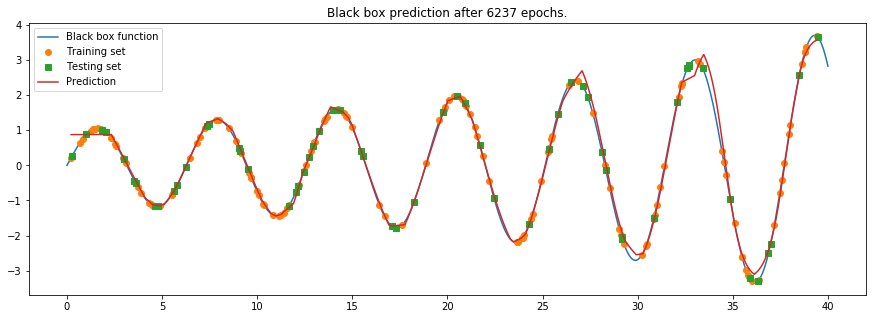

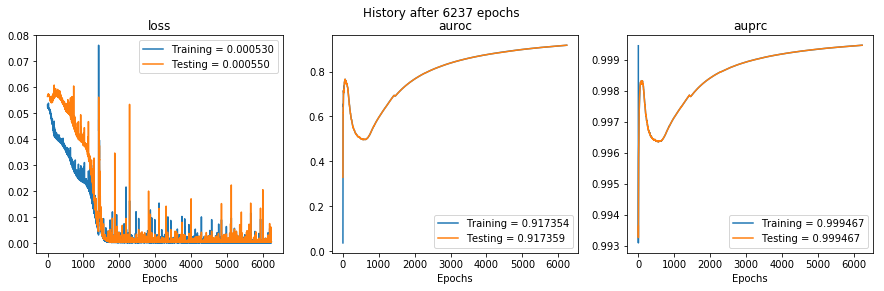

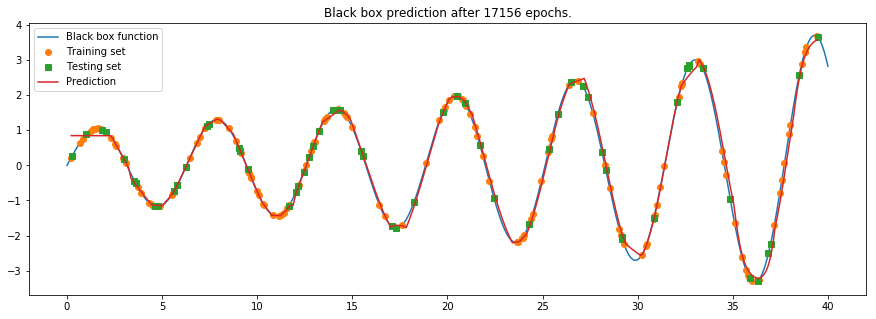

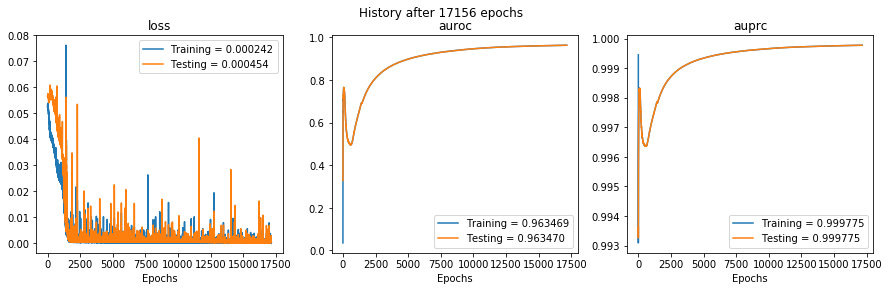

In [29]:
train(our_first_model, base_epochs, steps, x_train, x_test, y_train, y_test)

## Does it generalise well?
Does our trained model now approximate our black box in its entire domain? No, sadly it doesn't: we were able to show to it only datapoint for a limited range of values, so there is no reason to expect for it to be able to learn the correct values for points outsize the domain of the training set.

This effect can be mitigated by further developing the training set, by including more datapoints distributed in the function domain.

This is a reminder that neural networks (and most learning algorithms) seldom know something outside its training set domain and using it for generalise data is a risky move.

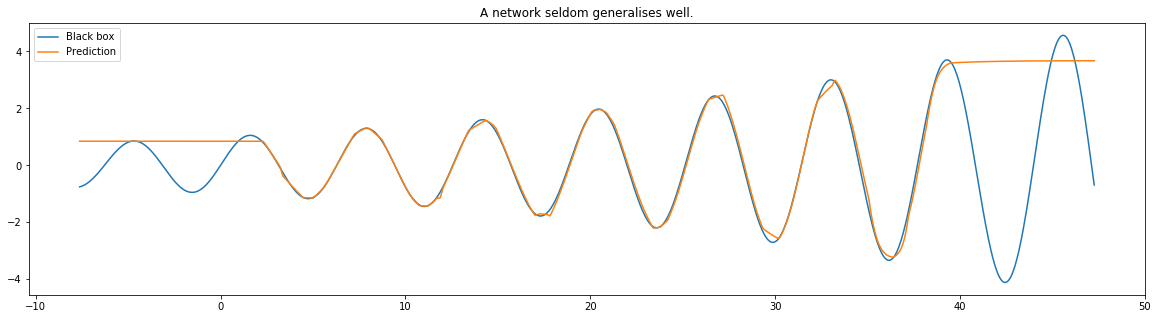

In [30]:
x = np.linspace(-0.2,1.2,endpoint=True,num=1000).reshape(-1, 1)
scaled_x = x_scaler.inverse_transform(x)
plt.figure(figsize=(20, 5))
plt.plot(scaled_x, black_box(scaled_x),  label="Black box")
plt.plot(
    scaled_x,
    y_scaler.inverse_transform(our_first_model.predict(x)),
    label='Prediction'
)
plt.legend()
plt.title("A network seldom generalises well.")
plt.show()

## Overfitting
We call *overfitting* a phenomenon for which the model learns almost exactly the training dataset, while failing to learn the testing set: let's see what that looks like.

We can cause our model to overfit simply by using a simpler optimiser, which uses a smaller step size without momentum, which causes the model to remain in a local minimum.

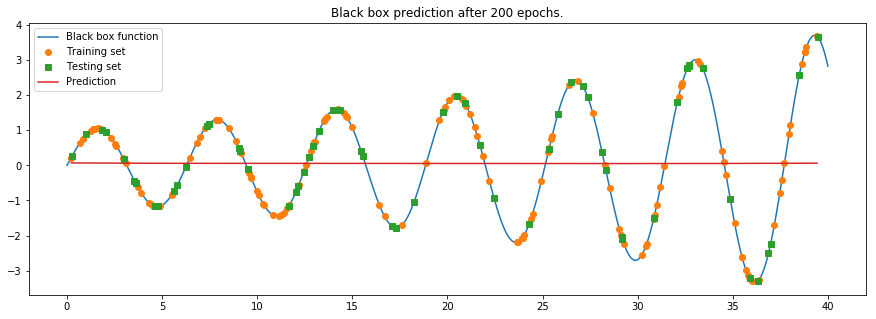

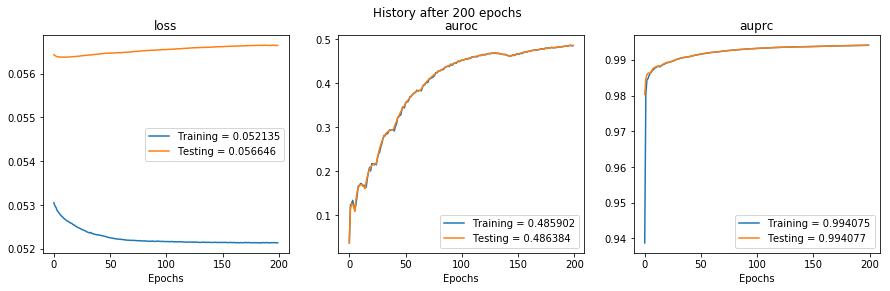

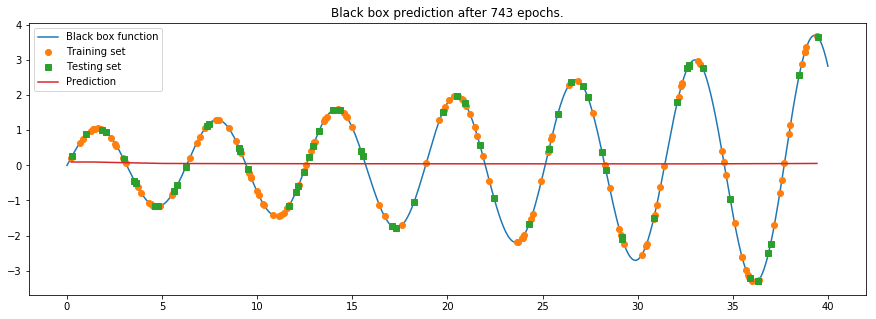

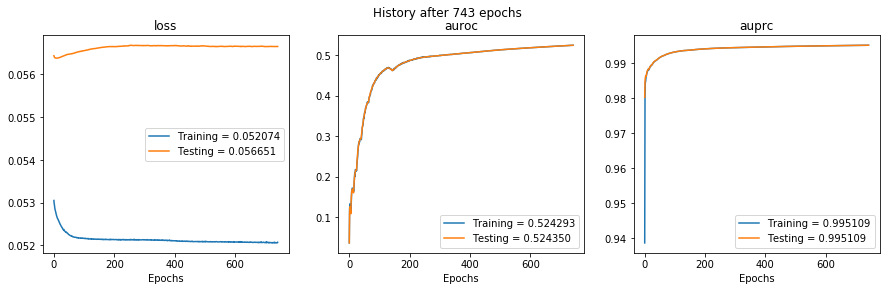

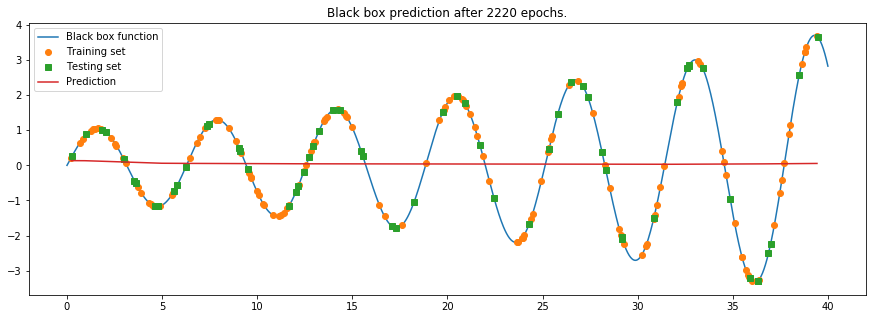

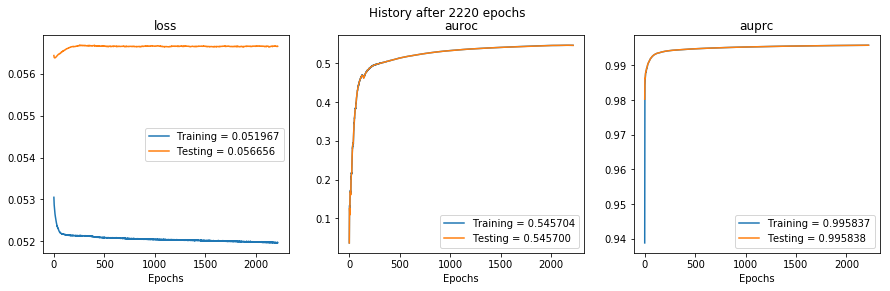

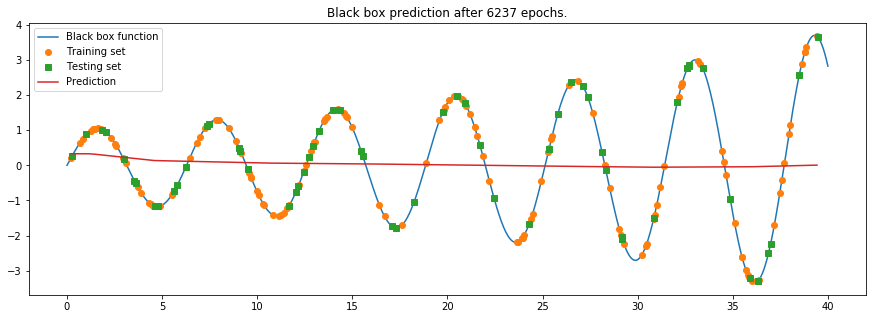

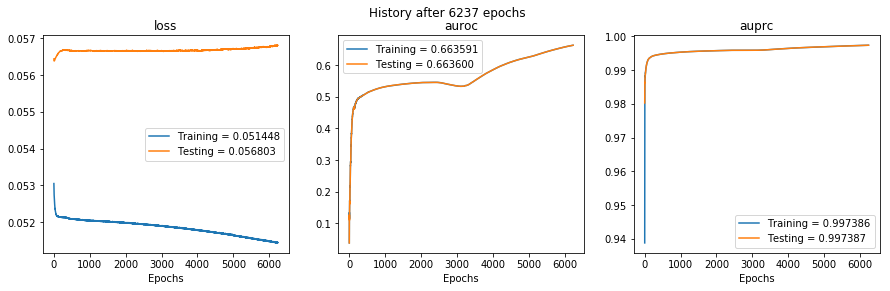

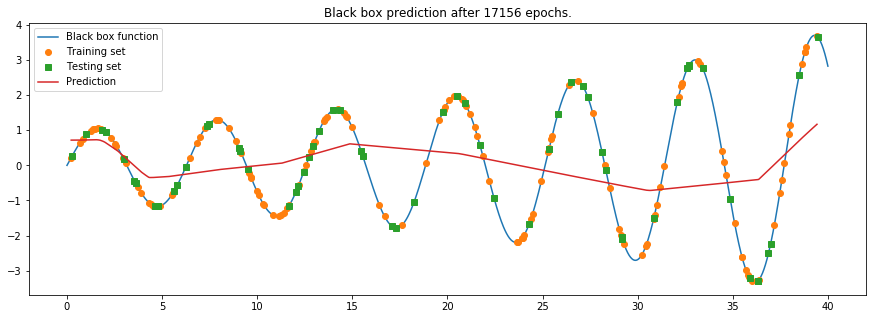

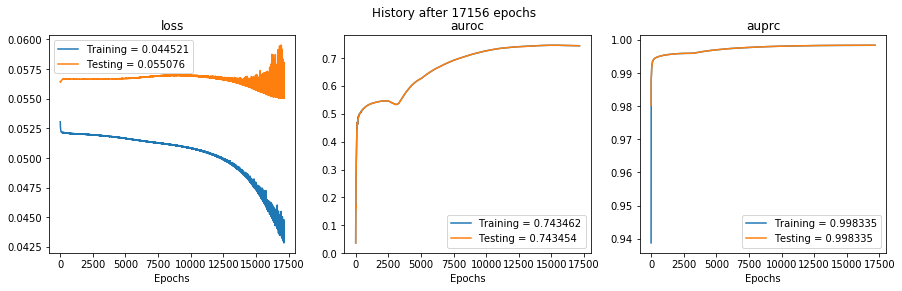

In [31]:
our_overfitting_model = mlp(breath, deapth, optimizer="sgd")
train(our_overfitting_model, base_epochs, steps, x_train, x_test, y_train, y_test)

## Bayesian optimization of hyper-parameters
The model we have created has lots of hyper-parameters: the number of hidden layers, the breadth of each layer, the batch size and so on: is there a way to determine which one has the best results?

One approach could be a grid search: testing every parameter combination, but that would mean combinatorial hell.

We will approach this issue instead using [bayesian optimization](https://github.com/fmfn/BayesianOptimization), an approach to hyper-parameters optimization which proceeds by creating a function which approximates the one of the model in function of the parameters, and then proceeds step by step to searching for an optimum.

Bayesian optimization is a complex topic and well beyond the goals of this lesson, but you can go [here](https://arxiv.org/pdf/1807.02811.pdf) to learn more. Here's the process in action:
![Baysian optimization](https://github.com/fmfn/BayesianOptimization/blob/master/examples/bayesian_optimization.gif?raw=true)

# Exercises
We will be looking to resolve the following exercises in the next lesson!

## 1 - Create a MLP model with two hidden layers

## 2 - Change and try different optimizers

## 3 - Predict different black box functions